In [13]:
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import sklearn.metrics as metrics

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

DATA = Path('../data/')

### Stationary(Median Imp) + Cases and Deaths

In [2]:
# Read different feature files
stationary_features = pd.read_csv(DATA/'processed/abridged_stationary_features_median_imputed.tsv', sep='\t')
# mobility_features = pd.read_csv(DATA/'processed/mobility_time_varying_features.tsv', sep='\t')
cases_deaths_features = pd.read_csv(DATA/'processed/abridged_time_varying_features.tsv', sep='\t')
# lockdown_features = pd.read_csv(DATA/'processed/abridged_time_based_features.tsv', sep='\t')

In [3]:
# Combine
all_features = cases_deaths_features.merge(stationary_features, on='countyFIPS', how='left')
# all_features = all_features.merge(lockdown_features, on='countyFIPS', how='left')
# all_features = all_features.merge(mobility_features, on=['countyFIPS', 'days_since_first_death'], how='left')

#### Predict Deaths in future

In [4]:
# Remove data points which haven't had at least 4 days since first death
num_tspoints = all_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]
counties_to_remove = list(num_tspoints[num_tspoints < 4].index)
print(f"Data from {len(counties_to_remove)} counties will be removed.")
to_keep = ~all_features.countyFIPS.isin(counties_to_remove)
all_features = all_features[to_keep].reset_index(drop=True)

Data from 56 counties will be removed.


In [5]:
# Split into train and test set
all_features.sort_values(['countyFIPS', 'days_since_first_death'], inplace=True)
test_indices = [
    ind for indlst in 
    all_features.reset_index().groupby('countyFIPS').agg({'index': lambda s: list(s)[-4:]})['index']
    for ind in indlst]

# Data
X = all_features.drop(['deaths-0', 'cases-0'], axis=1)
y = all_features['deaths-0']

# Encode labels
le = preprocessing.LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])

# Test set
# For each county, keep the data for the last 4 observed days as test set
X_test = X.loc[test_indices].reset_index(drop=True)
y_test = y.loc[test_indices].reset_index(drop=True)

# Train set
X_train = X.drop(test_indices, axis=0).reset_index(drop=True)
y_train = y.drop(test_indices, axis=0).reset_index(drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32654, 141), (32654,), (5724, 141), (5724,))

#### Baseline

In [6]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [7]:
y_pred = rf.predict(X_test)

In [9]:
metrics.mean_squared_error(y_test, y_pred)

224.78202562893077

In [16]:
metrics.mean_absolute_error(y_test, y_pred)

2.053401467505241

Text(0, 0.5, 'predicted')

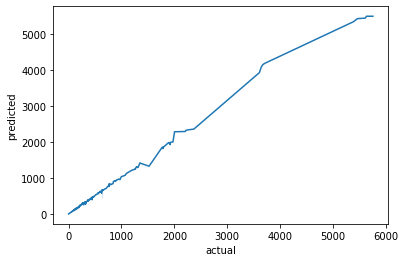

In [15]:
sns.lineplot(y_test, y_pred)
plt.xlabel('actual')
plt.ylabel('predicted')